# ``eBOSS`` Quasar Luminosity Function

Initiate notebook.

In [1]:
import pprint
from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import config
from luminosity import (
    LuminosityFunctionModeller,
    quasar_luminosity_PLE_model,
    quasar_luminosity_hybrid_model,
)

## Luminosity function data

Load luminosity function data.

In [2]:
DATA_FILE = "../data/input/luminosity_function_in_redshift_bins.txt"

raw_measurements = np.genfromtxt(DATA_FILE, unpack=True)

with open(DATA_FILE, 'r') as data_file:
    observables = tuple(
        map(
            lambda var_name: var_name.strip(" "), 
            data_file.readline().strip("#").strip("\n").split(",")
        )
    )

measurements = np.zeros_like(raw_measurements)
for var_idx, var_name in enumerate(observables):
    if var_name.startswith('Phi'):
        measurements[var_idx] = 10**raw_measurements[var_idx]
    elif var_name.startswith('d_Phi'):
        measurements[var_idx] = 10**raw_measurements[var_idx-1] \
            * (10**raw_measurements[var_idx] - 1)
    else:
        measurements[var_idx] = raw_measurements[var_idx]
    
luminosity_function_data = OrderedDict(zip(observables, measurements))

Determine redshift bins.

In [3]:
redshift_bin_labels = tuple(
    map(
        lambda redshift_range: r"${}$".format(redshift_range),
        [
            var_name.split("z_")[-1].replace("_", "<z<")
            for col_no, var_name in enumerate(luminosity_function_data) 
            if var_name.startswith('Phi')
        ]
    )
)

redshift_bin_centres = tuple(
    map(
        lambda redshift_range: np.mean(
            list(map(lambda endpoint: float(endpoint), redshift_range))
        ),
        [
            var_name.split("z_")[-1].split("_")
            for col_no, var_name in enumerate(luminosity_function_data)
            if var_name.startswith('Phi')
        ]
    )
)

redshift_bins = OrderedDict(zip(redshift_bin_labels, redshift_bin_centres))

## Luminosity function model

Specify luminosity function model.

In [4]:
modeller = LuminosityFunctionModeller.from_parameters_file(
    quasar_luminosity_PLE_model,
    -21.80,
    "../data/input/PLE_model_fits.txt"
)
luminosity_function_model = modeller.luminosity_function

## Luminosity function model comparisons

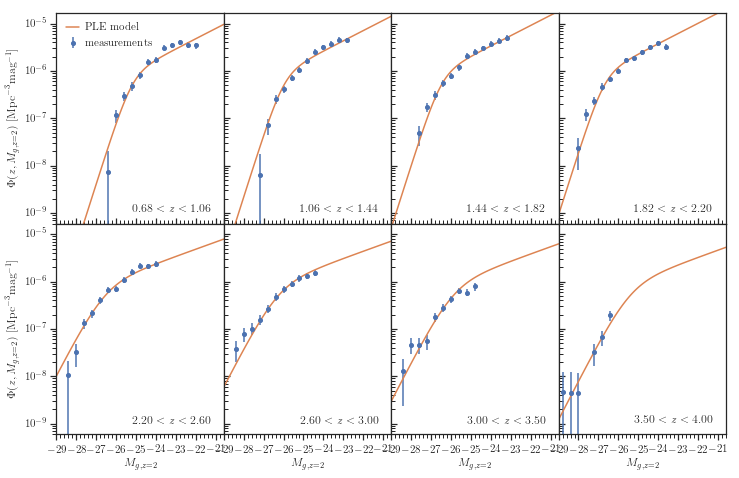

In [5]:
NUM_ROW, NUM_COL = 2, 4
ROW_SPAN, COL_SPAN = 4, 3

MAGNITUDE_RANGE = -29.0, -20.6
DENSITY_RANGE = 10**(-9.225), 10**(-4.775)

LEGEND_SETTINGS = dict(
    loc='upper left',
    handlelength=1.2, 
    handletextpad=0.5
)

NUM_INTERVALS = 100

magnitude_points = np.linspace(*MAGNITUDE_RANGE, num=NUM_INTERVALS+1)

plt.figure("Luminosity function", figsize=(12, 7.75))
for bin_idx, (bin_label, bin_redshift) in enumerate(redshift_bins.items()):
    
    row_idx, col_idx = bin_idx // NUM_COL, bin_idx % NUM_COL
    
    ax = plt.subplot2grid(
        (NUM_ROW * ROW_SPAN, NUM_COL * COL_SPAN), 
        (row_idx * ROW_SPAN, col_idx * COL_SPAN), 
        rowspan=ROW_SPAN, 
        colspan=COL_SPAN
    )
    
    if bin_idx == 0:
        plt.errorbar(
            luminosity_function_data['magnitude'],
            luminosity_function_data[observables[2*bin_idx+1]], 
            yerr=luminosity_function_data[observables[2*bin_idx+2]],
            fmt='o',
            markersize=4.,
            capsize=0.,
            label='measurements'
        )
        plt.plot(
            magnitude_points, 
            luminosity_function_model(magnitude_points, bin_redshift),
            label='PLE model'
        )
        plt.legend(**LEGEND_SETTINGS)
    else:
        plt.errorbar(
            luminosity_function_data['magnitude'],
            luminosity_function_data[observables[2*bin_idx+1]], 
            yerr=luminosity_function_data[observables[2*bin_idx+2]],
            fmt='o',
            markersize=4.,
            capsize=0.
        )
        plt.plot(
            magnitude_points,
            luminosity_function_model(magnitude_points, bin_redshift)
        )        
    
    plt.xscale('linear')
    plt.xlim(*MAGNITUDE_RANGE)
    
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1.))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.2))
    if row_idx + 1 < NUM_ROW:
        plt.tick_params(
            axis='x', which='both', direction='in', 
            labelbottom=False, labelsize=2
        )
    else:
        plt.xlabel(r"$M_{g,z=2}$")
        
    plt.yscale('log')    
    plt.ylim(*DENSITY_RANGE)
    
    if col_idx > 0:
        plt.tick_params(
            axis='y', which='both', direction='in',
            labelleft=False, labelsize=2
        )
    else:
        plt.ylabel(
            r"$\Phi(z,M_{g,z=2})$ "
            r"[$\textrm{Mpc}^{-3} \textrm{mag}^{-1}$]"
        )
    
    plt.title(bin_label, loc='right', position=(0.925, 0.025))

plt.subplots_adjust(hspace=0, wspace=0)